### Data Import and dataset loading

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Set data path
data_dir = '/Users/pulasthyareddy/Downloads/datasets/cnn_dataset'
#data_dir = '/Users/pulasthyareddy/Downloads/datasets/temp'


# Define transformation - resizing, normalization, data augmentation
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224,224)),
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values
])

# Load data
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Dataset info
print(f"Total images: {len(dataset)}")
print(f"Categories: {len(dataset.classes)}")
print(f"Sample shape: {dataset[0][0].shape}")

Total images: 100800
Categories: 36
Sample shape: torch.Size([1, 224, 224])


In [ ]:
#Data Splitting
test_size=int(0.2*len(dataset))
train_size=int(0.6*len(dataset))
val_size=int(0.2*len(dataset))

train,val,test=random_split(dataset,[train_size,val_size,test_size])


In [ ]:
batch_size=32
train_loader=DataLoader(train,batch_size=batch_size,shuffle=True)
val_loader=DataLoader(val,batch_size=batch_size)
test_loader=DataLoader(test,batch_size=batch_size)

## Defining Modified VGG - B


In [ ]:
import torch
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [ ]:
import torch
import torchinfo
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
from sklearn.metrics import roc_curve,auc,accuracy_score,precision_score,recall_score,f1_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle
import seaborn as sns

In [ ]:
class ModifiedVGG_13(nn.Module):
  def __init__(self,n_classes=36):
    super(ModifiedVGG_13, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)

    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
    self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)

    self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
    self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)

    self.conv7 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
    self.conv8 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)

    self.conv9 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
    self.conv10 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)

    self.dropout = nn.Dropout2d(0.5)


    self.fc1 = nn.Linear(512 * 7 * 7, 4096)
    self.fc2 = nn.Linear(4096,4096)
    self.fc3 = nn.Linear(4096, n_classes)

    self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    self.initialize_weights()

  def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # Initialize convolutional layers with Kaiming initialization
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                # Initialize fully connected layers with normal distribution
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.pool(x)

    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = self.pool(x)

    x = F.relu(self.conv5(x))
    x = F.relu(self.conv6(x))
    x = self.pool(x)

    x = F.relu(self.conv7(x))
    x = F.relu(self.conv8(x))
    x = self.pool(x)

    x = F.relu(self.conv9(x))
    x = F.relu(self.conv10(x))
    x = self.pool(x)

    x = torch.flatten(x,1)

    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = self.fc3(x)

    return x


In [ ]:
model = ModifiedVGG_13(n_classes=36).to(device)
print(torchinfo.summary(model))
# model = ModifiedVGG_13(n_classes=36)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.9,weight_decay=0.0005)
epochs=5

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.1,patience=2,verbose=True)

start_time=time.time()
best_val_accuracy = 0.0
best_model_weights = None
best_val_loss=float('inf')

start_time = time.time()
loss_train, acc_train, loss_val, acc_val = [], [], [], []

for epoch in range(epochs):
    running_loss = 0
    model.train()
    correct_predictions = 0
    total_samples = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_function(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, y_pred_idx = torch.max(output, 1)
        correct_predictions += (y_pred_idx == labels).sum().item()
        total_samples += labels.size(0)

    avg_train_loss = running_loss / len(train_loader)
    loss_train.append(avg_train_loss)
    accuracy = correct_predictions / total_samples
    acc_train.append(accuracy)

    # Validation
    model.eval()
    total_batch_loss_val = 0.0
    correct_pred_val = 0
    total_samples_val = 0

    with torch.no_grad():
        for images_val, labels_val in val_loader:
            images_val, labels_val = images_val.to(device), labels_val.to(device)
            # images_val, labels_val = images_val, labels_val
            output_val = model(images_val)
            val_loss = loss_function(output_val, labels_val)
            total_batch_loss_val += val_loss.item()
            _, label_idx = torch.max(output_val, 1)
            correct_pred_val += (label_idx == labels_val).sum().item()
            total_samples_val += labels_val.size(0)

    avg_loss_val = total_batch_loss_val / len(val_loader)
    loss_val.append(avg_loss_val)
    accur_val = correct_pred_val / total_samples_val
    acc_val.append(accur_val)


    if accur_val > best_val_accuracy:
        best_val_accuracy = accur_val
        best_model_weights = model.state_dict()


    # Stepping up learning rate scheduler
    print(f"Epoch {epoch} , Learning Rate: {optimizer.param_groups[0]['lr']}")
    scheduler.step(accur_val)

    print(f"Train Loss: {avg_train_loss:.2f}, Validation Loss: {avg_loss_val:.2f}, Training Acc: {accuracy:.2f}, Validation Acc: {accur_val:.2f}")

train_time = (time.time() - start_time) / 60
print(f"Total training time: {train_time:.2f} minutes")
print(f"Best validation accuracy: {best_val_accuracy:.2f}")
opt_time=train_time
torch.save(best_model_weights, 'part4_model.pt')



# Load the best model weights
model.load_state_dict(torch.load('part4_model.pt'))
model.eval()

# Testing
total_batch_loss_test, correct_pred_test, total_samples_test = 0, 0, 0
actuals, pred, prob = [], [], []

with torch.no_grad():
    for test_images, test_labels in test_loader:
        img_test, label_test = test_images.to(device), test_labels.to(device)
        # img_test, label_test = test_images, test_labels
        output_test = model(img_test)
        test_loss = loss_function(output_test, label_test)
        total_batch_loss_test += test_loss.item()
        _, label_idx = torch.max(output_test, 1)
        correct_pred_test += (label_idx == label_test).sum().item()
        total_samples_test += test_labels.size(0)

        actuals.extend(label_test.cpu().numpy())
        pred.extend(label_idx.cpu().numpy())
        prob.extend(output_test.cpu().numpy())

avg_loss_test = total_batch_loss_test / len(test_loader)
acc_test = correct_pred_test / total_samples_test
print(f"Test accuracy: {acc_test:.2f}")

loss_test = [avg_loss_test for i in range(epochs)]
accuracy_test = [acc_test for i in range(epochs)]

# For ROC
actuals = np.array(actuals)
pred = np.array(pred)
prob = np.array(prob)
bins = label_binarize(actuals, classes=range(36))
opt_acc=acc_test


Layer (type:depth-idx)                   Param #
ModifiedVGG_13                           --
├─Conv2d: 1-1                            640
├─Conv2d: 1-2                            36,928
├─Conv2d: 1-3                            73,856
├─Conv2d: 1-4                            147,584
├─Conv2d: 1-5                            295,168
├─Conv2d: 1-6                            590,080
├─Conv2d: 1-7                            1,180,160
├─Conv2d: 1-8                            2,359,808
├─Conv2d: 1-9                            2,359,808
├─Conv2d: 1-10                           2,359,808
├─Dropout2d: 1-11                        --
├─Linear: 1-12                           102,764,544
├─Linear: 1-13                           16,781,312
├─Linear: 1-14                           147,492
├─MaxPool2d: 1-15                        --
Total params: 129,097,188
Trainable params: 129,097,188
Non-trainable params: 0
Epoch 0 , Learning Rate: 0.01
Train Loss: 0.79, Validation Loss: 0.33, Training Acc: 0.76, Va

In [ ]:
accuracy=accuracy_score(actuals,pred)
precision=precision_score(actuals,pred,average='macro')
recall=recall_score(actuals,pred,average='macro')
f1=f1_score(actuals,pred,average='macro')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'f1 score: {f1}')

Accuracy: 0.9221230158730159
Precision: 0.9212604340048018
Recall: 0.9212849938875274
f1 score: 0.9210046498861231


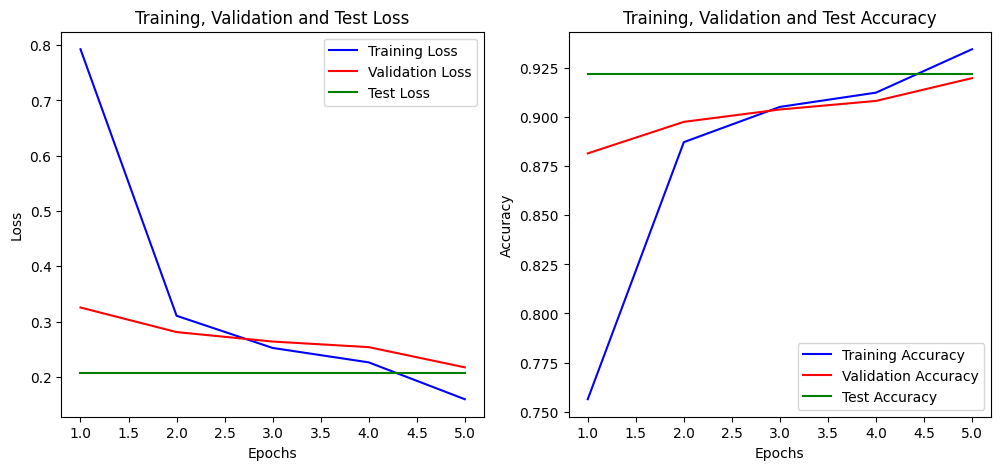

In [ ]:
#Training validation and test losses
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(loss_train) + 1), loss_train, 'b', label='Training Loss')
plt.plot(range(1, len(loss_val) + 1), loss_val, 'r', label='Validation Loss')
plt.plot(range(1, len(loss_test) + 1),loss_test,color='green',label="Test Loss")
plt.title('Training, Validation and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1,2,2)
plt.plot(range(1, len(acc_train) + 1), acc_train, 'b', label='Training Accuracy')
plt.plot(range(1, len(acc_train) + 1), acc_val, 'r', label='Validation Accuracy')
plt.plot(range(1, len(accuracy_test) + 1),accuracy_test,color='green',label="Test Accuracy")
plt.title('Training, Validation and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

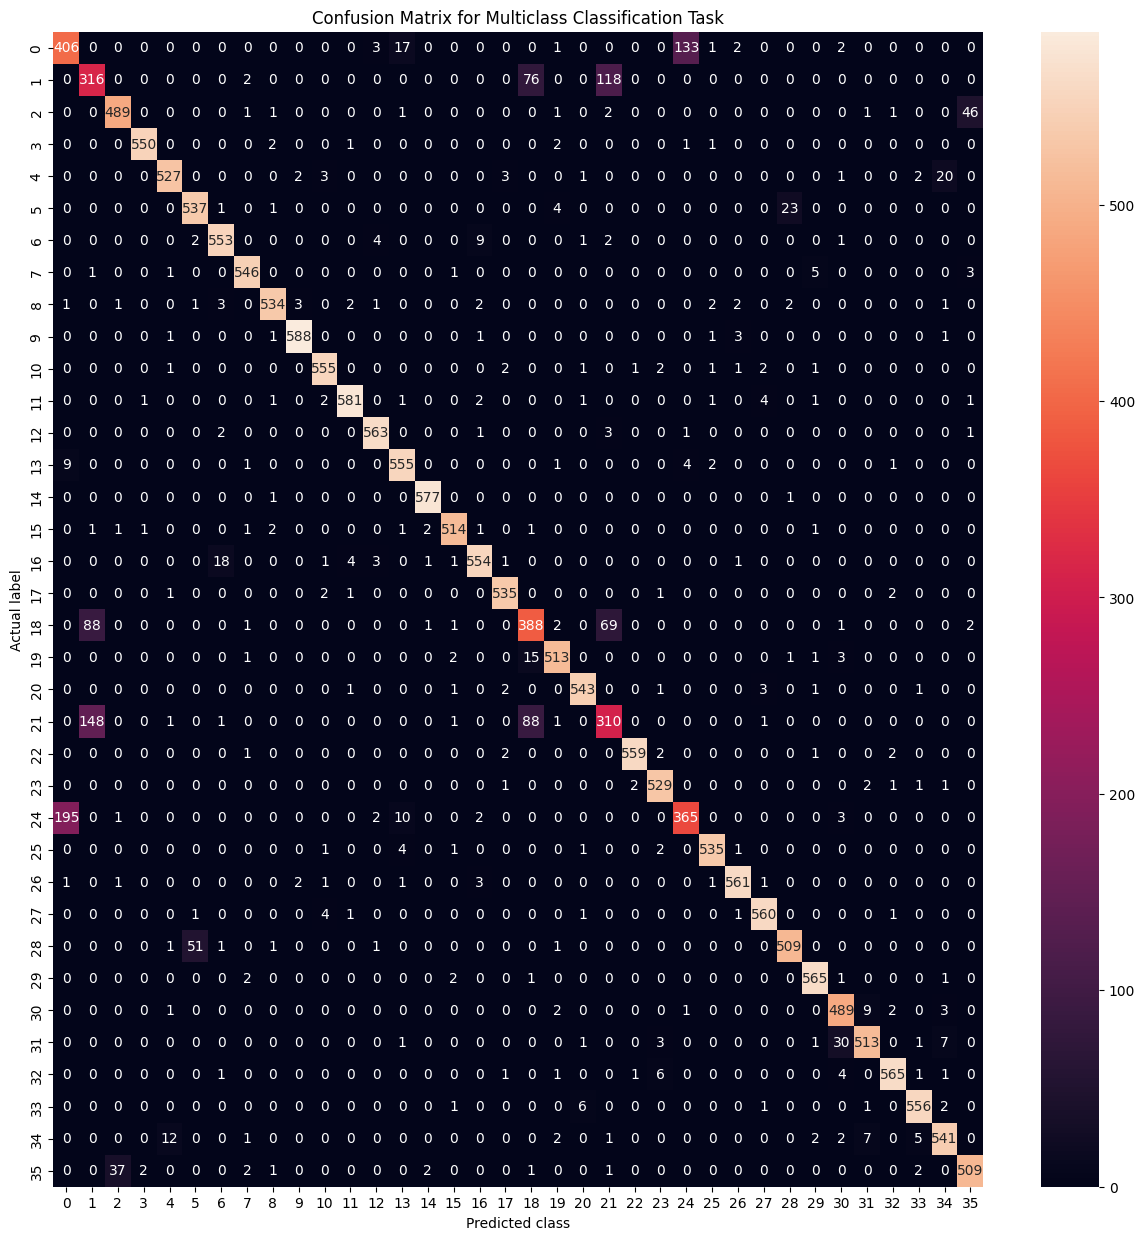

In [ ]:
#Confusion matrices
cm=confusion_matrix(actuals,pred)

plt.figure(figsize=(15,15))
sns.heatmap(cm,annot=True,fmt="d",xticklabels=range(36),yticklabels=range(36))
plt.xlabel("Predicted class")
plt.ylabel("Actual label")
plt.title("Confusion Matrix for Multiclass Classification Task")
plt.show()


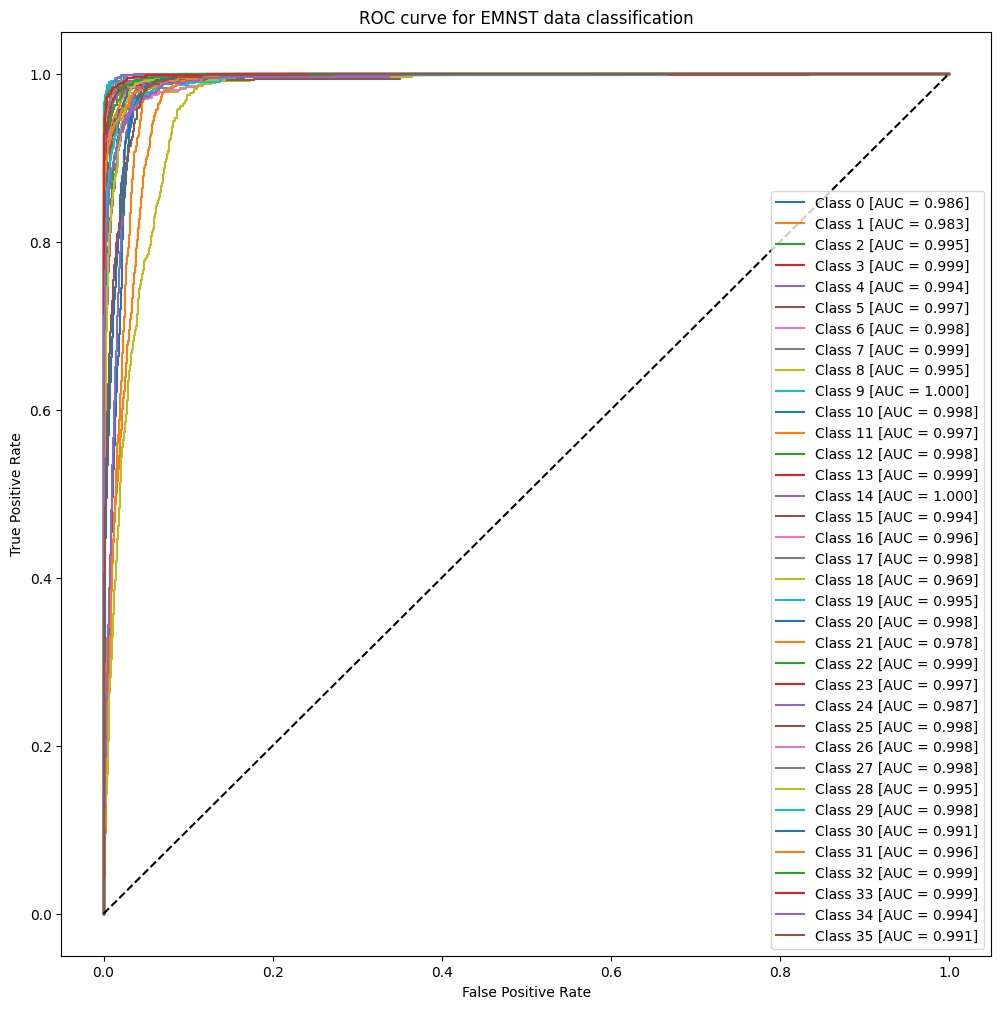

In [ ]:
#ROC curve
fpr=dict()
tpr=dict()
roc_auc=dict()
for i in range(36):
    fpr[i],tpr[i],_=roc_curve(bins[:,i],prob[:,i])
    roc_auc[i]=auc(fpr[i],tpr[i])

plt.figure(figsize=(12,12))
for i in range(36):
    plt.plot(fpr[i],tpr[i],label=f'Class {i} [AUC = {roc_auc[i]:.3f}]')

plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for EMNST data classification')
plt.legend(loc='lower right')
plt.show()
